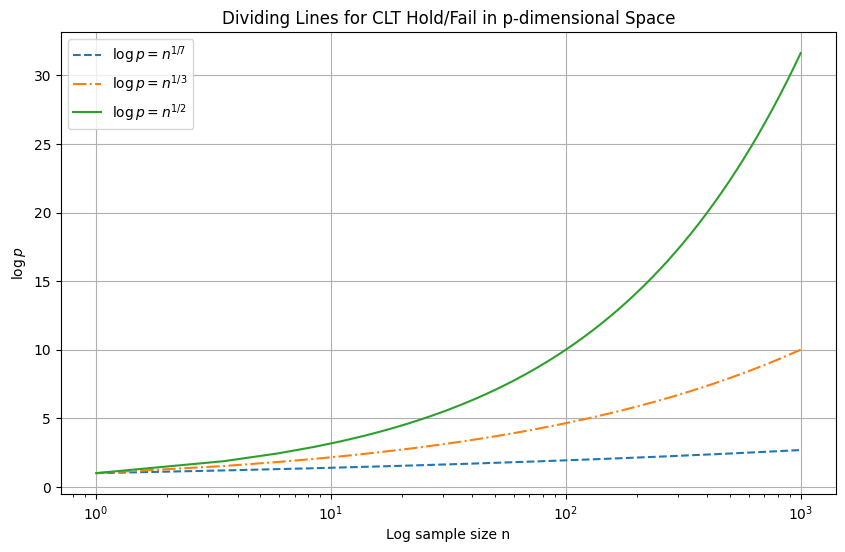

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define n range
n = np.linspace(1, 1000, 400)
n = n[n > 0]  # to avoid log(0) issues

# Calculate log p for different conditions
log_p_n_1_7 = n**(1/7)
log_p_n_1_3 = n**(1/3)
log_p_n_1_2 = n**(1/2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n, log_p_n_1_7, label=r'$\log p = n^{1/7}$', linestyle='--')
plt.plot(n, log_p_n_1_3, label=r'$\log p = n^{1/3}$', linestyle='-.')
plt.plot(n, log_p_n_1_2, label=r'$\log p = n^{1/2}$')

plt.xlabel('Log sample size n')
plt.xscale('log')
plt.ylabel(r'$\log p$')
plt.title('Dividing Lines for CLT Hold/Fail in p-dimensional Space')
plt.legend()
plt.grid(True)
plt.show()


### Central Limit Theorem (CLT) Introduction

The Central Limit Theorem is one of the fundamental theorems in probability theory. It states that, under certain conditions, the sum of a large number of independent and identically distributed (iid) random variables, each with a finite mean and variance, will approximate a normal distribution, regardless of the underlying distribution.

**Key Points:**
- **Sum of iid Variables**: The variables being summed should be independent of each other and follow the same probability distribution.
- **Normal Distribution Formation**: As more variables are added, the distribution of the sum tends towards a normal distribution.
- **Implications**: This theorem is foundational for many statistical methods, including hypothesis testing and confidence intervals, particularly when the sample size is large.

Below, we will demonstrate this concept by progressively adding random samples from a non-normal distribution and observing how their sum tends towards a normal distribution as we increase the number of samples.

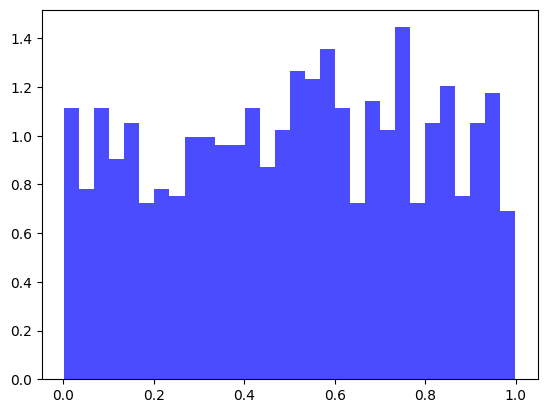

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
n_samples = 1000
n_bins = 30
n = 100  # Number of terms in the sum

# Generate samples
data = np.random.rand(n_samples, n)  # Uniform distribution over [0, 1)

fig, ax = plt.subplots()

# Initial histogram
hist, bins, patches = ax.hist(data[:, 0], bins=n_bins, density=True, color='blue', alpha=0.7)

def update_hist(frame_num):
    ax.clear()
    sums = data[:, :frame_num+1].sum(axis=1)
    ax.hist(sums, bins=n_bins, density=True, color='blue', alpha=0.7)
    ax.set_title(f'Sum of {frame_num+1} uniform random variables')
    ax.set_xlim(0, n)
    ax.set_ylim(0, 10)

ani = animation.FuncAnimation(fig, update_hist, frames=n, repeat=False)

plt.show()

### Independent and Identically Distributed (iid) Vectors

In the context of the CLT, the assumption that each component of the vector or each variable in the sequence is independent and identically distributed (iid) is crucial. Here's what this means:

- **Independent**: The outcome of one variable does not affect the outcome of another.
- **Identically Distributed**: Each variable follows the same probability distribution across the entire process.

**Demonstration**:
We will simulate several vectors where each component is drawn from the same distribution and is independent of others in the vector. This setup is the bedrock for applying the CLT in multi-dimensional settings as explored in the attached paper on high-dimensional CLT.

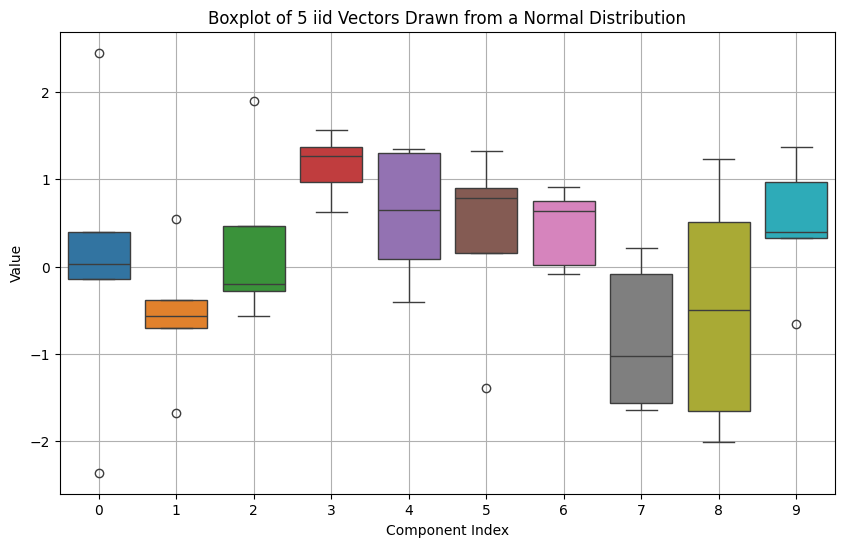

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd

# Generating iid vectors
n_vectors = 5
vector_length = 10  # Length of each vector
vectors = np.random.normal(loc=0, scale=1, size=(n_vectors, vector_length))

# Convert to DataFrame for easier plotting
df = pd.DataFrame(vectors)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot of 5 iid Vectors Drawn from a Normal Distribution')
plt.xlabel('Component Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

The Relevance of CLT in High Dimensions
The Central Limit Theorem's utility extends profoundly into high-dimensional spaces, which are increasingly prevalent in fields like statistical inference and machine learning. As data sets grow larger and more complex, encompassing numerous variables across vast dimensions, understanding the distributional characteristics of these data sets becomes critical. In high dimensions, variables can interact in complex ways, significantly impacting the performance and reliability of statistical models and machine learning algorithms.

High-dimensional CLT helps in simplifying these complexities by assuring that under certain conditions, even in large dimensional spaces, the sum or average of random variables will approximate a normal distribution. This approximation allows for the use of techniques and formulas derived under normality assumptions, which are otherwise complex to compute directly in higher dimensions.

Hyper-Rectangles: Definition and Visualization
A hyper-rectangle in a high-dimensional space is a direct generalization of a rectangle in two dimensions. In 3D, it becomes a rectangular prism, and in higher dimensions, though hard to visualize, it can be thought of as a product of intervals.

Definition: In an n-dimensional space, a hyper-rectangle is defined by the product of intervals along each dimension. Mathematically, it is represented as:
(i=1 to n) PI[a(i), b(i)] where a(i) <= b(i) for each i. 
Here, a(i) and b(i) are the lower and upper bounds of the interval along the i-th dimension.

Visualizing Hyper-Rectangles as Projections

While we can't visually represent dimensions beyond three, we can understand higher-dimensional rectangles through projections onto lower dimensions. For instance, projecting a 4D hyper-rectangle onto 2D might result in viewing only the ranges along two chosen dimensions, ignoring the others.

Limits of Projection Thinking:

Projections from high to low dimensions can obscure critical relationships and variances inherent in the higher dimensions.

Lower-dimensional projections might oversimplify the complexities of higher-dimensional relationships, leading to incorrect interpretations or missed nuances.

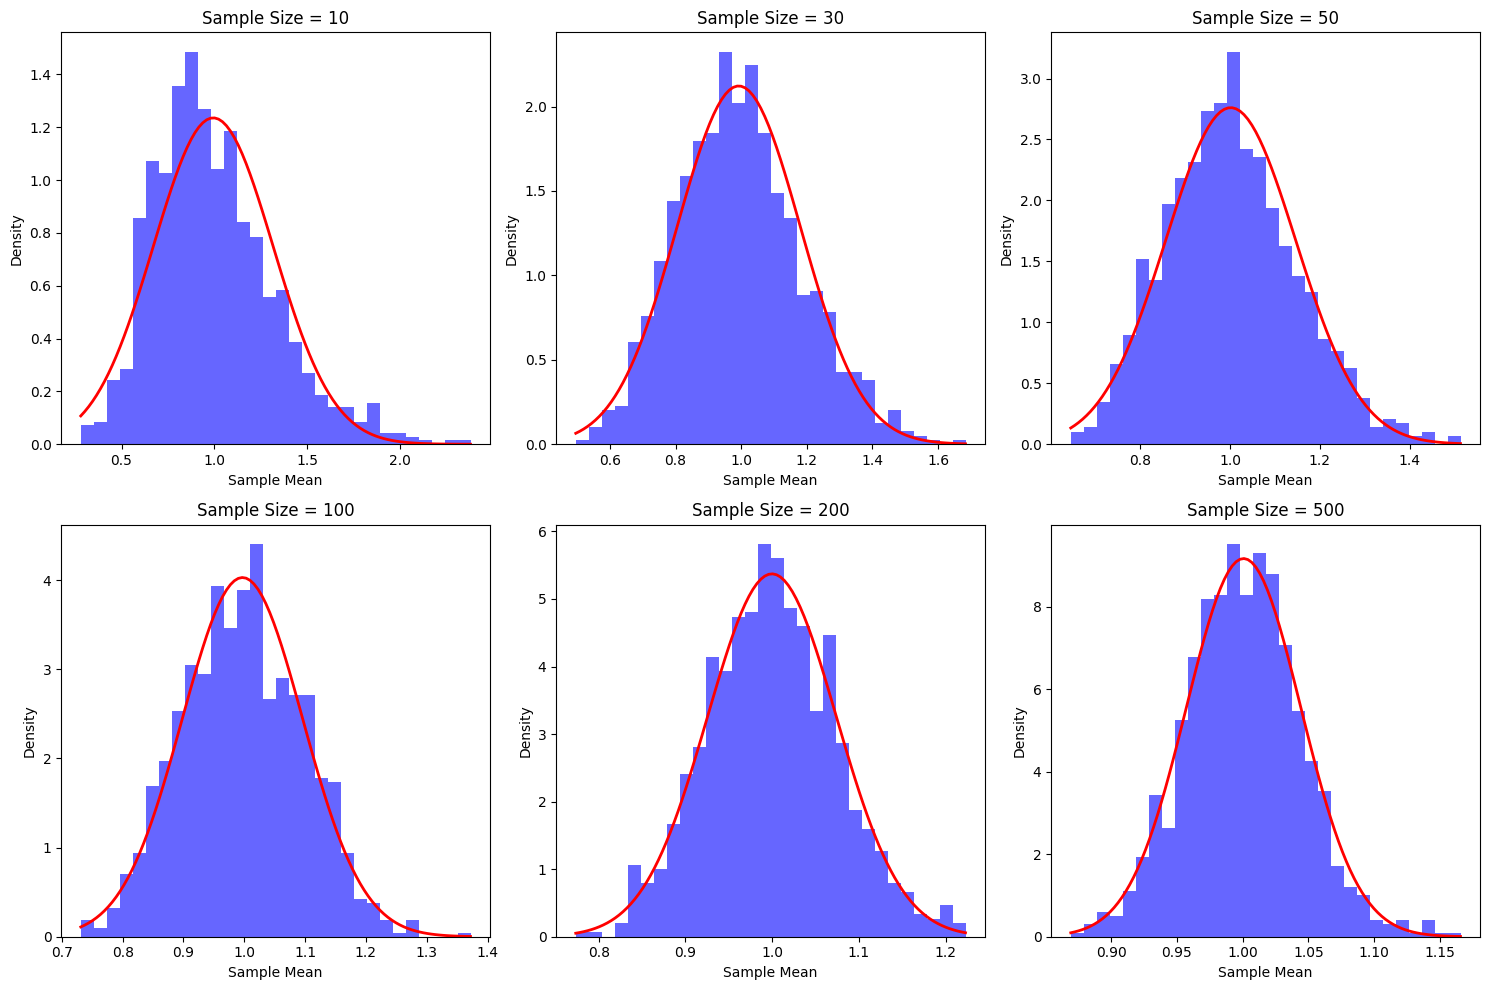

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Parameters
sample_sizes = [10, 30, 50, 100, 200, 500]  # Different sample sizes to test
num_samples = 1000  # Number of times we sample to compute means

# Store means for different sample sizes
sample_means = {n: [] for n in sample_sizes}

# Generate samples and compute means
for n in sample_sizes:
    for _ in range(num_samples):
        samples = np.random.exponential(scale=1, size=n)  # Exponential distribution
        sample_mean = np.mean(samples)
        sample_means[n].append(sample_mean)

# Plot histograms and normal PDF for each sample size
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, n in enumerate(sample_sizes):
    mean_of_means = np.mean(sample_means[n])
    variance_of_means = np.var(sample_means[n])
    sigma = np.sqrt(variance_of_means)

    # Theoretical normal
    x = np.linspace(min(sample_means[n]), max(sample_means[n]), 100)
    normal_pdf = stats.norm.pdf(x, mean_of_means, sigma)

    # Histogram
    axes[idx].hist(sample_means[n], bins=30, density=True, alpha=0.6, color='b')
    axes[idx].plot(x, normal_pdf, 'r', linewidth=2)
    axes[idx].set_title(f'Sample Size = {n}')
    axes[idx].set_xlabel('Sample Mean')
    axes[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()


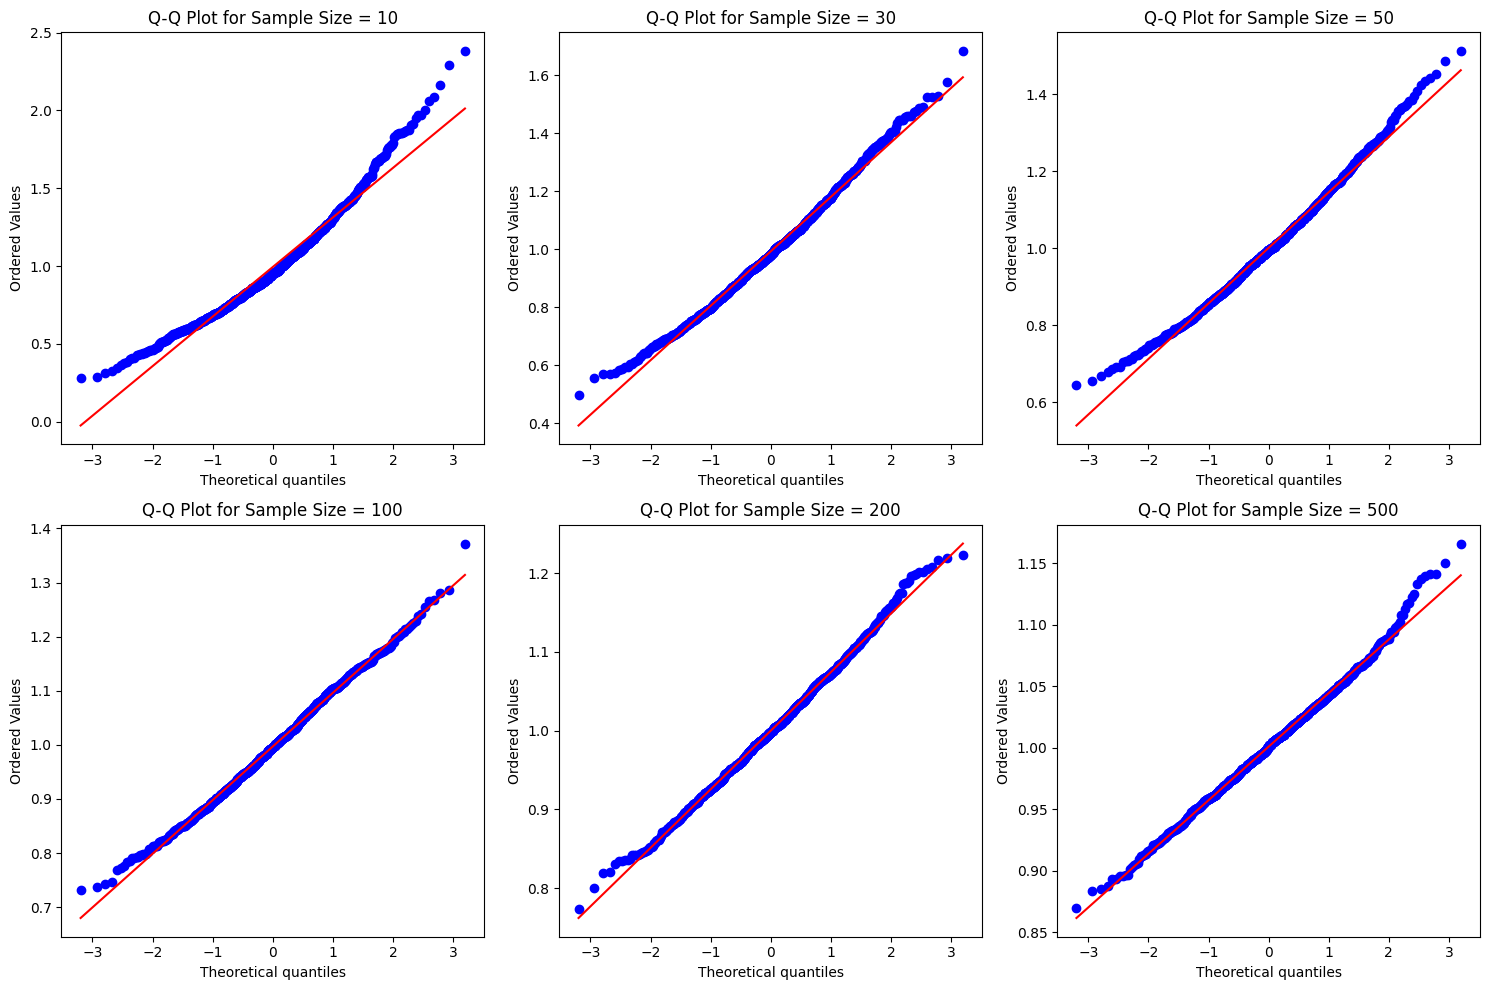

In [5]:
# Q-Q plots to check the normality of the distribution of sample means
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, n in enumerate(sample_sizes):
    stats.probplot(sample_means[n], dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot for Sample Size = {n}')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def generate_samples(max_p, max_n):
    # Use random normal distribution; adapt distribution as needed for specific CLT testing
    return np.random.normal(0, 1, size=(max_n, max_p))

def test_clt(data, p, n):
    sample_means = np.mean(data[:n, :p], axis=1)
    # Perform normality test, return result (pass/fail)
    result, _ = stats.normaltest(sample_means)
    return 'pass' if result > 0.05 else 'fail'  # using p-value from normality test

import matplotlib.pyplot as plt

def plot_boundaries(sample_results, sample_sizes, dimensions):
    x = np.log(sample_sizes)
    y = np.log(dimensions)
    colors = ['green' if result == 'pass' else 'red' for result in sample_results]
    
    plt.scatter(x, y, color=colors, label='CLT Test Result')
    plt.plot(x, np.log(x)**0.5, label=r'$\log p = n^{1/2}$', linestyle='--')
    plt.plot(x, np.log(x)**(1/3), label=r'$\log p = n^{1/3}$', linestyle='-.')
    plt.plot(x, np.log(x)**(1/7), label=r'$\log p = n^{1/7}$', linestyle=':')
    plt.xlabel(r'$\log n$')
    plt.ylabel(r'$\log p$')
    plt.legend()
    plt.title('CLT Boundary Conditions')
    plt.show()

max_p = int(1e10)
max_n = 1000
data = generate_samples(max_p, max_n)

sample_results = []
sample_sizes = np.geomspace(1, max_n, num=100)  # Logarithmically spaced sample sizes
dimensions = np.geomspace(1, max_p, num=100)    # Logarithmically spaced dimensions

for n in sample_sizes:
    for p in dimensions:
        result = test_clt(data, int(p), int(n))
        sample_results.append(result)

plot_boundaries(sample_results, sample_sizes, dimensions)

MemoryError: Unable to allocate 72.8 TiB for an array with shape (1000, 10000000000) and data type float64

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import scipy.stats as stats
import os

# Function to generate samples and test CLT
def test_clt(n, p):
    # Generate samples
    data = np.random.normal(0, 1, size=(n, p)).astype(np.float32)
    
    # Compute sample means
    sample_means = np.mean(data, axis=1)
    
    # Perform normality test on sample means
    _, p_value = stats.normaltest(sample_means)
    
    return p_value > 0.05  # Return True if the normality test passes

# Parameters
max_p = 1000000
sample_sizes = [10, 100, 1000]  # More manageable sizes
dimensions = np.geomspace(1, max_p, num=20).astype(int)  # Log-scaled dimensions

# Using joblib to parallelize
results = Parallel(n_jobs=8)(delayed(test_clt)(n, p) for n in sample_sizes for p in dimensions)


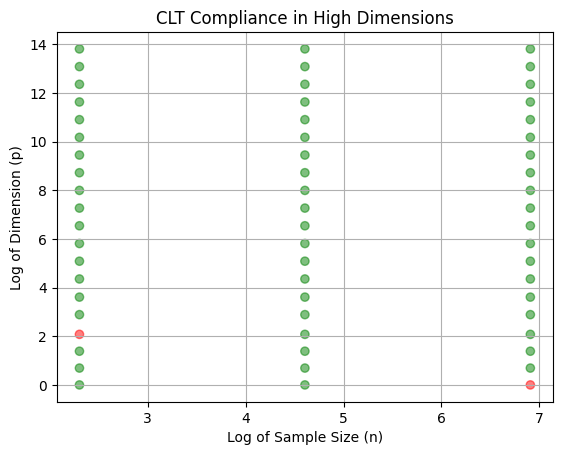

In [ ]:
import matplotlib.pyplot as plt


def plot_results(sample_sizes, dimensions, results):
    colors = ['green' if result else 'red' for result in results]
    log_p = np.log([p for _ in sample_sizes for p in dimensions])
    log_n = np.log([n for n in sample_sizes for _ in dimensions])

    plt.scatter(log_n, log_p, c=colors, alpha=0.5)
    plt.xlabel('Log of Sample Size (n)')
    plt.ylabel('Log of Dimension (p)')
    plt.title('CLT Compliance in High Dimensions')
    plt.grid(True)
    plt.show()

plot_results(sample_sizes, dimensions, results)


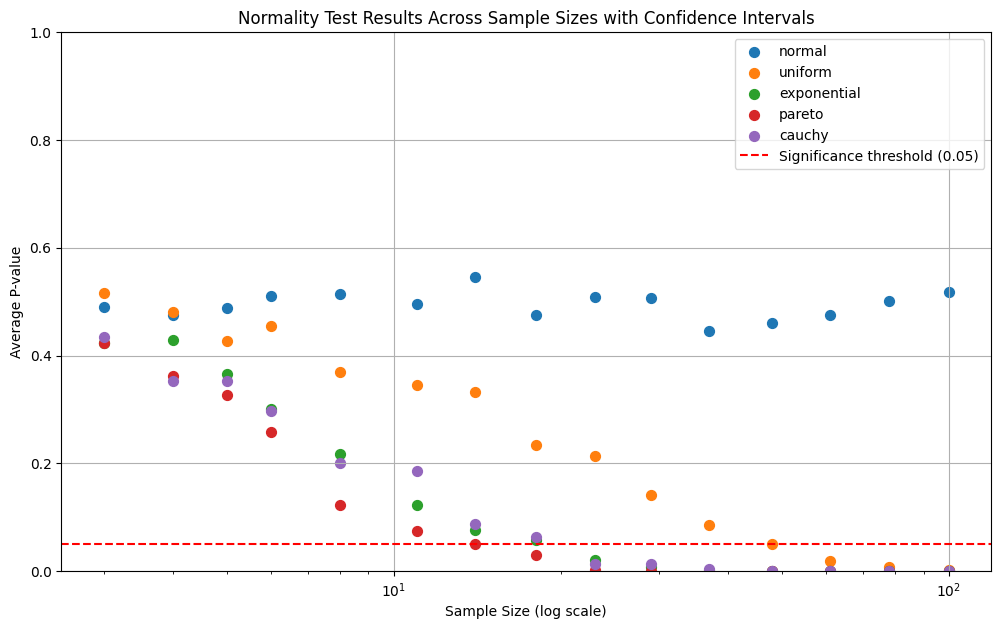

In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define different distributions
distributions = {
    'normal': lambda n: np.random.normal(loc=0, scale=1, size=n),
    'uniform': lambda n: np.random.uniform(low=0, high=1, size=n),
    'exponential': lambda n: np.random.exponential(scale=1, size=n),
    'pareto': lambda n: (np.random.pareto(a=3, size=n) + 1) * 10,
    'cauchy': lambda n: np.random.standard_cauchy(size=n)
}

# Function to compute mean p-values and confidence intervals
def test_normality_at_sample_size(dist_func, sample_size, num_experiments=100):
    p_values = []
    for _ in range(num_experiments):
        samples = dist_func(sample_size)
        if len(samples) >= 3:  # Ensure there are enough samples for Shapiro-Wilk test
            _, p_value = stats.shapiro(samples)
            p_values.append(p_value)
    
    # Check if p_values is not empty to avoid errors
    if p_values:
        mean_p = np.mean(p_values)
        conf_int = np.percentile(p_values, [2.5, 97.5])  # 95% confidence interval
        return mean_p, conf_int
    else:
        return np.nan, (np.nan, np.nan)  # Return NaN values if no tests were performed

results = {dist_name: {'mean_ps': [], 'conf_ints': []} for dist_name in distributions}

for dist_name, dist_func in distributions.items():
    for size in sample_sizes:
        mean_p, conf_int = test_normality_at_sample_size(dist_func, size)
        results[dist_name]['mean_ps'].append(mean_p)
        results[dist_name]['conf_ints'].append(conf_int)

def plot_clt_results(sample_sizes, results):
    plt.figure(figsize=(12, 7))
    for dist_name, data in results.items():
        mean_ps = np.array(data['mean_ps'])
        conf_ints = np.array(data['conf_ints'])
        
        # Ensure that p-values and confidence intervals are within [0, 1]
        mean_ps = np.clip(mean_ps, 0, 1)
        conf_ints[:, 0] = np.clip(conf_ints[:, 0], 0, 1)
        conf_ints[:, 1] = np.clip(conf_ints[:, 1], 0, 1)

        # Calculate error bars such that they do not extend beyond [0, 1]
        lower_errors = mean_ps - conf_ints[:, 0]
        upper_errors = conf_ints[:, 1] - mean_ps

        #plt.errorbar(sample_sizes, mean_ps, yerr=[lower_errors, upper_errors], fmt='o',
                     #label=dist_name, capsize=5, linestyle='-', marker='o')
        plt.scatter(sample_sizes, mean_ps, s=50, marker='o', label=dist_name)
    
    plt.axhline(y=0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
    plt.title('Normality Test Results Across Sample Sizes with Confidence Intervals')
    plt.xlabel('Sample Size (log scale)')
    plt.ylabel('Average P-value')
    plt.xscale('log')
    plt.ylim(0, 1)  # Set the limits of the y-axis to only show valid p-value ranges
    plt.legend()
    plt.grid(True)
    plt.show()

plot_clt_results(sample_sizes, results)

In [19]:
# Import necessary libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the distribution functions
distributions = {
    'uniform': lambda size: np.random.uniform(low=0, high=1, size=size),
    'exponential': lambda size: np.random.exponential(scale=1, size=size),
    'pareto': lambda size: (np.random.pareto(a=3, size=size) + 1) * 10,
    'cauchy': lambda size: np.random.standard_cauchy(size=size)
}

# Function to generate high-dimensional data
def generate_high_d_data(distribution_func, num_samples, dimension):
    data = distribution_func(num_samples * dimension)
    return data.reshape(num_samples, dimension)

# Function to test normality across dimensions
def test_normality_across_dimensions(data):
    means = np.mean(data, axis=0)
    _, p_value = stats.shapiro(means)
    return p_value

# Function to plot results
def plot_results(dimensions, sample_sizes, p_values, dist_name):
    plt.figure(figsize=(12, 7))
    X, Y = np.meshgrid(sample_sizes, dimensions)
    p_values = np.array(p_values).reshape(len(dimensions), len(sample_sizes))
    plt.contourf(X, Y, p_values, levels=[0, 0.05, 1], cmap='RdYlGn', alpha=0.7)
    plt.colorbar(label='P-value')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Sample Size')
    plt.ylabel('Dimensionality')
    plt.title(f'Normality Test Results for {dist_name}')
    plt.show()

# Define dimensions and sample sizes
dimensions = [1] + list(np.logspace(1, 3, num=5).astype(int))  # 1D to 1000D
sample_sizes = np.logspace(1, 4, num=5).astype(int)  # From 10 to 10,000 samples

# Run the experiment and collect results
results = {}
for dist_name, dist_func in distributions.items():
    p_values = []
    for dimension in dimensions:
        for num_samples in sample_sizes:
            data = generate_high_d_data(dist_func, num_samples, dimension)
            p_value = test_normality_across_dimensions(data)
            p_values.append(p_value)
    results[dist_name] = p_values
    plot_results(dimensions, sample_sizes, p_values, dist_name)


ValueError: Data must be at least length 3.